In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import seaborn
from matplotlib.lines import Line2D
from astropy.cosmology import Planck18
plt.rc("font", family="serif")
plt.rc("text", usetex=True)
import warnings
warnings.filterwarnings('ignore')
import astropy.coordinates as coord
import astropy.units as u
import corner
import seaborn as sns

In [2]:
with open('../processed_data/Baseline_v_3_0/Baselinev30_NEW_large_numimages=2_batch001.pkl', 'rb') as f:
    doubles = pickle.load(f)
with open('../processed_data/Baseline_v_3_0/Baselinev30_NEW_large_numimages=4_batch001.pkl', 'rb') as f:
    quads = pickle.load(f)
with open('../processed_data/Baseline_v_3_0/Baselinev30_unlensed_gband_batch001.pkl', 'rb') as f:
    sne = pickle.load(f)
    
print("Doubles: ", len(doubles))
print("Quads: ", len(quads))
print("Unlensed: ", len(sne))

Doubles:  5000
Quads:  5000
Unlensed:  5000


In [3]:
# masks

# Rolling / non-rolling
md_nonrol = (doubles['obs_start']) <= 60768
md_rol = (doubles['obs_start']) > 60768
mq_nonrol = (quads['obs_start']) <= 60768
mq_rol = (quads['obs_start']) > 60768

# Survey
md_WFD = (doubles['survey']) == 'WFD'
md_DDF = (doubles['survey']) == 'DDF'
md_gal = (doubles['survey']) == 'galactic plane'
mq_WFD = (quads['survey']) == 'WFD'
mq_DDF = (quads['survey']) == 'DDF'
mq_gal = (quads['survey']) == 'galactic plane'

# Detected
md_detected = (doubles['mag_method'] == True) | (doubles['mult_method'] == True)
md_detected_micro = (doubles['mag_method_micro'] == True) | (doubles['mult_method_micro'] == True)
md_detected_peak = (doubles['mag_method_peak'] == True) | (doubles['mult_method_peak'] == True)
md_nondetect_micro = (doubles['mag_method_micro'] == False) & (doubles['mult_method_micro'] == False)
md_nondetect = (doubles['mag_method'] == False) & (doubles['mult_method'] == False)
mq_detected_micro = (quads['mag_method_micro'] == True) | (quads['mult_method_micro'] == True)
mq_detected = (quads['mag_method'] == True) | (quads['mult_method'] == True)
mq_nondetect_micro = (quads['mag_method_micro'] == False) & (quads['mult_method_micro'] == False)
mq_nondetect = (quads['mag_method'] == False) & (quads['mult_method'] == False)
mq_detected_peak = (quads['mag_method_peak'] == True) | (quads['mult_method_peak'] == True)

md_detected_micro_mag = (doubles['mag_method_micro'] == True)
md_detected_micro_mult = (doubles['mult_method_micro'] == True)
mq_detected_micro_mag = (quads['mag_method_micro'] == True)
mq_detected_micro_mult = (quads['mult_method_micro'] == True)

md_mult_peak = (doubles['mult_method_peak'] == True)
md_mag_peak = (doubles['mag_method_peak'] == True)
mq_mult_peak = (quads['mult_method_peak'] == True)
mq_mag_peak = (quads['mag_method_peak'] == True)


In [5]:
print("Doubles:")
print(((doubles['mag_method_micro'])).sum())
print(((doubles['mult_method_micro'])).sum())
print(" ")
print("Quads:")
print(((quads['mag_method_micro'])).sum())
print(((quads['mult_method_micro'])).sum())

Doubles:
874
1503
 
Quads:
2714
2453


In [6]:
doubles['theta_E'][doubles['theta_E'] > 0.5]

0       0.937871
1       0.535325
2       0.525605
7       0.721876
9       0.800618
          ...   
4988    0.573896
4989    0.515200
4992    0.627733
4993    0.877100
4998    1.273717
Name: theta_E, Length: 2844, dtype: float64

In [7]:
quads['theta_E'][quads['theta_E'] > 0.5]

0       0.716876
1       0.791792
3       0.825486
5       0.977010
7       1.407854
          ...   
4989    1.043705
4992    0.653118
4993    0.671601
4995    0.916633
4999    0.809785
Name: theta_E, Length: 2916, dtype: float64

In [11]:
def separation(x_image, y_image):
    """
    Calculates the maximum image separation.

    :param x_image: array of length [num_images] containing the x coordinates of the supernova images in arcsec
    :param y_image: array of length [num_images] containing the y coordinates of the supernova images in arcsec
    :return: maximum separation between images in arcsec (float)
    """
    if len(x_image) == 2:
        sep = ((x_image[0] - x_image[1])**2 + (y_image[0] - y_image[1])**2)**0.5
        return sep
    elif len(x_image) == 4:
        sep1 = ((x_image[0] - x_image[1]) ** 2 + (y_image[0] - y_image[1]) ** 2) ** 0.5
        sep2 = ((x_image[0] - x_image[2]) ** 2 + (y_image[0] - y_image[2]) ** 2) ** 0.5
        sep3 = ((x_image[0] - x_image[3]) ** 2 + (y_image[0] - y_image[3]) ** 2) ** 0.5
        sep4 = ((x_image[1] - x_image[2]) ** 2 + (y_image[1] - y_image[2]) ** 2) ** 0.5
        sep5 = ((x_image[1] - x_image[3]) ** 2 + (y_image[1] - y_image[3]) ** 2) ** 0.5
        sep6 = ((x_image[2] - x_image[3]) ** 2 + (y_image[2] - y_image[3]) ** 2) ** 0.5
        separations = np.array([sep1, sep2, sep3, sep4, sep5, sep6])
        max_sep = max(separations)
        return max_sep
    
max_sep_doubles, max_sep_quads = [], []

for i in range(len(doubles)):
    max_sep_doubles.append(separation(doubles['image_x'][i], doubles['image_y'][i]))
    max_sep_quads.append(separation(quads['image_x'][i], quads['image_y'][i]))

In [46]:
# Redo image multiplicity method:
N = 0
M = 0
P = 0
Q = 0

for i in range(len(doubles)):
    # old condition: max_sep > 0.5
    if max_sep_doubles[i] > 0.5:
        if (np.nanmax(doubles['obs_snr_micro'][i], axis=0) > 5).sum() > 1:
            N += 1
            
    # new condition: max_sep > 2/3 PSF for at least 2 (3) images with S/N > 5 for doubles (quads)      
    cond_psf = doubles['obs_psf'][i] < 3/2 * max_sep_doubles[i]
    cond_snr1 = (doubles['obs_snr_micro'][i] > 5)[:,0]
    cond_snr2 = (doubles['obs_snr_micro'][i] > 5)[:,1]
    cond_im1 = (cond_psf & cond_snr1).sum()
    cond_im2 = (cond_psf & cond_snr2).sum()
    if cond_im1 > 0 and cond_im2 > 0:
        M += 1

print("Doubles:")
print("Simple method: ", N) 
print("New method:    ", M)
        
for i in range(len(quads)):
    # old condition: max_sep > 0.5
    if max_sep_quads[i] > 0.5:
        if (np.nanmax(quads['obs_snr_micro'][i], axis=0) > 5).sum() > 2:
            P += 1
            
    # new condition: max_sep > 2/3 PSF for at least 2 (3) images with S/N > 5 for doubles (quads)
    # so each image should have at least once at the SAME time a good enough psf & S/N
    cond_psf = quads['obs_psf'][i] < 3/2 * max_sep_quads[i]
    cond_snr1 = (quads['obs_snr_micro'][i] > 5)[:,0]
    cond_snr2 = (quads['obs_snr_micro'][i] > 5)[:,1]
    cond_snr3 = (quads['obs_snr_micro'][i] > 5)[:,2]
    cond_snr4 = (quads['obs_snr_micro'][i] > 5)[:,3]
    cond_im1 = (cond_psf & cond_snr1).sum()
    cond_im2 = (cond_psf & cond_snr2).sum()
    cond_im3 = (cond_psf & cond_snr3).sum()
    cond_im4 = (cond_psf & cond_snr4).sum()
    if np.count_nonzero(np.array([cond_im1, cond_im2, cond_im3, cond_im4])) > 2:
        Q += 1

print(" ")
print("Quads:")
print("Simple method: ", P) 
print("New method:    ", Q)

Doubles:
Simple method:  1612
New method:     1610
 
Quads:
Simple method:  2512
New method:     2561


(0.0, 6.0)

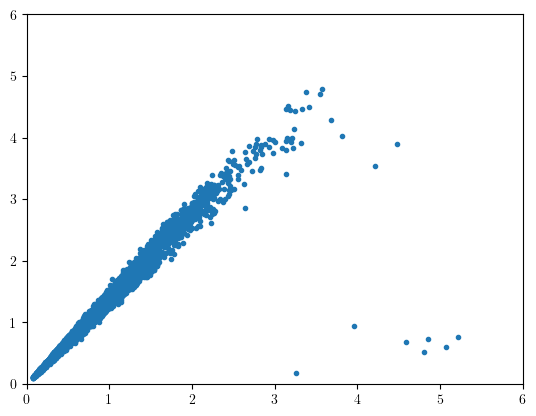

In [17]:
plt.plot(doubles['theta_E'] * 2**0.5, max_sep_doubles, '.')
plt.xlim(0,6)
plt.ylim(0,6)

In [18]:
doubles.keys()

Index(['time_series', 'z_source', 'z_lens', 'H0', 'theta_E', 'obs_peak',
       'obs_times', 'obs_bands', 'model_mag', 'obs_mag', 'obs_mag_error',
       'obs_snr', 'obs_mag_unresolved', 'mag_unresolved_error',
       'snr_unresolved', 'macro_mag', 'source_x', 'source_y', 'time_delay',
       'time_delay_distance', 'image_x', 'image_y', 'gamma_lens', 'e1_lens',
       'e2_lens', 'g1_shear', 'g2_shear', 'micro_kappa', 'micro_gamma',
       'micro_s', 'micro_peak', 'stretch', 'colour', 'Mb', 'obs_start',
       'obs_end', 'mult_method_peak', 'mult_method', 'mult_method_micro',
       'mag_method_peak', 'mag_method', 'mag_method_micro', 'coords',
       'obs_skybrightness', 'obs_psf', 'obs_lim_mag', 'obs_N_coadds', 'survey',
       'rolling', 'obs_mag_micro', 'mag_micro_error', 'obs_snr_micro',
       'mag_unresolved_micro', 'mag_unresolved_micro_error',
       'snr_unresolved_micro', 'peak_magnitudes', 'peak_magnitudes_micro'],
      dtype='object')

In [41]:
max_sep = 0.5
print(3/2 * max_sep)

print(doubles['obs_psf'][6])
print(doubles['obs_psf'][6] < 3/2 * max_sep)
print((doubles['obs_snr_micro'][6] > 5)[:,0])
print(((doubles['obs_snr_micro'][6] > 5)[:,0] & (doubles['obs_psf'][6] < 3/2 * max_sep)).sum())

0.75
[0.5909786  0.87171812 0.68405071 0.75659389 0.66915752 0.71950463
 0.82792185 0.68153398 0.76056068 0.89542173 0.57347387 0.56661415
 1.03093899 1.0203771  1.01903959 0.69806173 0.68663664 0.66915696
 0.70080605 0.6454912  0.64495416 0.72376906 1.09361592 1.42362466
 0.78936023 0.66965696 0.6449679  0.60105209 0.91170942 1.68170851
 1.19401993 0.87756573 0.82315267 1.0221836  0.86838502 1.27940817
 1.01565627 0.83879992 0.89865879 0.73906409 0.94092879 0.78844483
 0.90419396 1.22558891 1.00453341 1.05934409 0.77749327 1.30250949
 0.8788203  0.99127398 1.43125238]
[ True False  True False  True  True False  True False False  True  True
 False False False  True  True  True  True  True  True  True False False
 False  True  True  True False False False False False False False False
 False False False  True False False False False False False False False
 False False False]
[False False False False False False False  True  True False  True  True
  True False  True  True  True  True  T

In [26]:
doubles['obs_snr_micro'][6]

array([[ 0.        ,  0.        ],
       [        nan,  0.        ],
       [        nan,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [12.97030679,         nan],
       [15.12156398,         nan],
       [ 4.50244254,         nan],
       [32.49334649,  0.        ],
       [25.1216058 ,  0.        ],
       [10.48475393,  1.13337703],
       [ 4.1159619 ,  0.        ],
       [ 8.8875112 ,  1.60138123],
       [21.36869728,  4.57897411],
       [16.91260084,  4.24965661],
       [ 9.5227704 ,  4.42217126],
       [17.33501502,  9.99332588],
       [15.84374562,  7.57228233],
       [21.22846682, 14.00234179],
       [16.8641469 , 11.80287476],
       [ 3.62375899,  5.63430155],
       [13.90452342, 13.59017999],
       [15.80265155, 18.93471994],
       [ 3.75328411,  7.06466011],
       [ 6.87108624,  6.44551788],
       [11.68804949, 18.72589452],
       [ 6.11053337,